<a href="https://www.kaggle.com/code/ashutoshrudraksh/is-it-a-snake-creating-a-model-from-your-own-data?scriptVersionId=106741013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# this is credited to Fast.ai Teams
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-tran

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

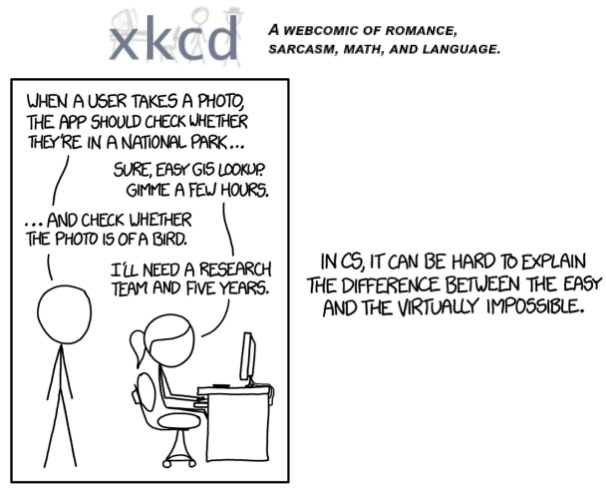

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "snakes photos"
1. Use DuckDuckGo to search for images of "sheltopusiks"
1. Fine-tune a pretrained neural network to recognise these  groups
1. Try running this model on a picture of a snakes and see if it works.

## Step 1: Download images of streets

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a snakes photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('snake photos', max_images=1)
urls[0]

Searching for 'snake photos'


'https://infotel.ca/news/medialibrary/image/orig-mediaitemid62749-1831.jpg'

...and then download a URL and take a look at it:

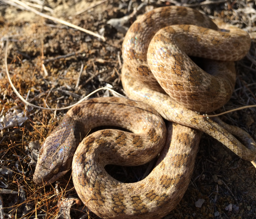

In [5]:
from fastdownload import download_url
dest = 'snake.jpg'
download_url(urls[0],dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


Hisss!

Now let's do the same with "sheltopusiks" photos:

Searching for 'sheltopusiks'


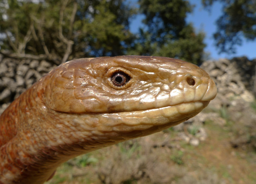

In [6]:
download_url(search_images('sheltopusiks', max_images=1)[0], 'sheltopusiks.jpg',show_progress=False)
Image.open('sheltopusiks.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "snakes" and "sheltopusiks", and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'snake','sheltopusiks'
path = Path('snake_or_not')

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photos')) #path and urls 
    sleep(10) #pause btw searches to avoid over-loading servev
    resize_image(path/o, max_size=400,dest=path/o)


Searching for 'snake photos'
Searching for 'sheltopusiks photos'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path)) 
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

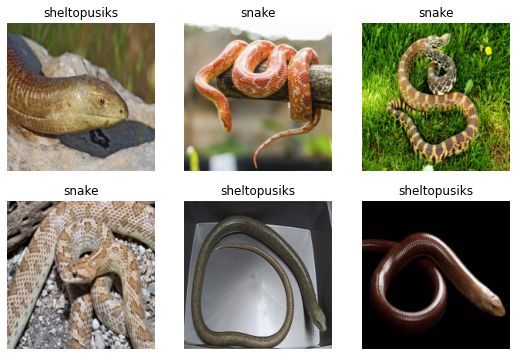

In [9]:
dls = DataBlock(
blocks = (ImageBlock, CategoryBlock),
get_items = get_image_files,
splitter = RandomSplitter(valid_pct=0.2, seed = 42),
get_y = parent_label,
item_tfms=Resize(192,method='squish')).dataloaders(path,bs=32)
dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.701931,4.541208,0.454545,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.186180,3.245057,0.454545,00:06
1,0.884081,2.063499,0.454545,00:05
2,0.719802,0.988780,0.454545,00:05
3,0.562592,0.360173,0.181818,00:05
4,0.460334,0.115094,0.000000,00:05
5,0.381037,0.056921,0.000000,00:05
6,0.326029,0.034678,0.000000,00:05
7,0.282682,0.028007,0.000000,00:05
8,0.249099,0.025359,0.000000,00:05
9,0.225243,0.026346,0.000000,00:04


Not a fantastic error rate 10% but we have only performed a very quick check on training image quality.

This is my first project with the [fast.ai](https://www.fast.ai/) course being hosted live at The University of Queensland from April-June 2022.

## Step 3: Use our model to predict

Let's see what our model thinks about that bird we downloaded at the start:

This is gonna be tricky since "snakes" look very alike to "sheltopusiks"

In [11]:
is_normal,_,probs = learn.predict(PILImage.create('snake.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's a snake: {probs[0]:.4f}")

This is a: snake.
Probability it's a snake: 0.0149


Woohoo! done great!

<AxesSubplot:>

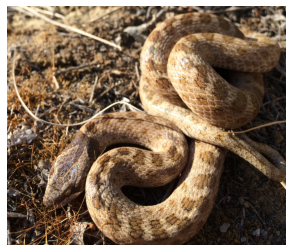

In [12]:
# great take look wooo! its not snake.
img = PILImage.create('snake.jpg')
img.show()

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.